In [1]:
%load_ext autoreload
%autoreload 2
import stim
import numpy as np
import matplotlib.pyplot as plt
import sinter
from typing import List
import surface_general_defect
from surface_general_defect import LogicalQubit

In [27]:
from pathlib import Path
import subprocess
import math
import os
import stim, sinter
import matplotlib.pyplot as plt

# --- repo paths ---
REPO_ROOT = Path("..").resolve()
CPP_BIN   = REPO_ROOT / "cpp/build/superstabilizer_splicing"

# Your original (non-ent) circuits live here:
BASE_DIR  = REPO_ROOT / "python_deformation_generator" / "stim_circuits_d9_centerline_spaced"

# Where to write per-entanglement-rate outputs
ENT_ROOT  = REPO_ROOT / "python_deformation_generator" / "ent_rate_sweeps"
ENT_ROOT.mkdir(parents=True, exist_ok=True)

# --- entanglement-rate sweep (MHz) ---
# You can choose linear or log spacing. Here’s a compact log-ish set:
# ENT_RATES_MHZ = [1, 2, 5, 10, 20, 50, 100, 200, 500]
ENT_RATES_MHZ = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]

# --- how to pass entanglement rate to the C++ tool ---
# Adjust ENT_ARG to match your binary’s flag (e.g. "-E", "--entanglement-rate", etc.)
ENT_ARG       = "--entanglement-rate-hz"      # <-- change if your binary uses a different flag
ENT_UNITS_HZ  = True              # if True, pass Hz; if False, pass MHz as-is


In [10]:
DEPOL1 = 0.0005
DEPOL2 = 0.003
READOUT_ERR = 0.001

def gen_circuit_with_deforms(d, r, missing_coords):
    # error probs aren't the point
    logical_qubit = surface_general_defect.LogicalQubit(d, READOUT_ERR, DEPOL1, DEPOL2, missing_coords=missing_coords, get_metrics=True)
    if len(logical_qubit.defect) == 0:
        circuit = logical_qubit.generate_stim(r)
    else:
        circuit = logical_qubit.generate_stim_shell(r)
    return logical_qubit, circuit

In [11]:
def gen_stim_file(d, r, missing_coords, folder=None, fname=None):
    if missing_coords is None:
        missing_coords = []
    if folder is None:
        folder = "."
    if fname is None:
        fname = f"surface_d{d}r{r}_cut{len(missing_coords)}.stim"
    file = f"{folder}/{fname}"
    print(fname)
    
    logical_qubit, circuit = gen_circuit_with_deforms(d, r, missing_coords)

    import os
    os.makedirs(folder, exist_ok=True)
    circuit.to_file(file)

In [14]:
from pathlib import Path
import re

# --- glob all .stim files ---
stim_files = sorted(BASE_DIR.glob("*.stim"))

generated = []

for p in stim_files:
    name = p.name
    # Try to extract ndefects (from pattern like ndefects3)
    m = re.search(r"ndefects(\d+)", name)
    ndefects = int(m.group(1)) if m else 0

    # Determine if baseline or defect
    if "baseline" in name or "ndefects0" in name:
        series = "baseline"
    else:
        series = "defect"

    generated.append({
        "path": p.resolve(),
        "series": series,
        "ndefects": ndefects,
        "missing_coords": [],  # can't recover easily; optional
    })

print(f"✅ Found {len(generated)} stim files in {BASE_DIR}")
for g in generated:
    print(f"{g['series']:8s}  ndefects={g['ndefects']:2d}  -> {g['path'].name}")


✅ Found 6 stim files in /Users/eli/dev/superstabilizer_splicing/python_deformation_generator/stim_circuits_d9_centerline_spaced
baseline  ndefects= 0  -> d9_r27_ndefects0_baseline.stim
defect    ndefects= 1  -> d9_r27_ndefects1.stim
defect    ndefects= 2  -> d9_r27_ndefects2.stim
defect    ndefects= 3  -> d9_r27_ndefects3.stim
defect    ndefects= 4  -> d9_r27_ndefects4.stim
defect    ndefects= 5  -> d9_r27_ndefects5.stim


In [28]:
def hz_from_mhz(mhz: float) -> int:
    return int(round(mhz * 1e6))

def out_dir_for_rate(mhz: float) -> Path:
    d = ENT_ROOT / f"ent_{int(mhz)}MHz"
    d.mkdir(parents=True, exist_ok=True)
    return d

def ent_output_name(src: Path) -> Path:
    # keep the original filename, but ensure '-ent' is present before extension
    stem = src.stem
    if not stem.endswith("-ent"):
        stem = stem + "-ent"
    return src.with_name(stem + ".stim")

# Verify binary and inputs exist
assert CPP_BIN.exists() and os.access(CPP_BIN, os.X_OK), f"Missing or not executable: {CPP_BIN}"
assert BASE_DIR.exists(), f"Missing base dir {BASE_DIR}"
assert generated, "Expected 'generated' (baseline + defects) to exist from previous step."

# Run the C++ tool for each rate
for rate_mhz in ENT_RATES_MHZ:
    out_dir = out_dir_for_rate(rate_mhz)
    print(f"\n=== Entanglement rate: {rate_mhz} MHz → {out_dir} ===")
    for g in generated:
        inp = g["path"]
        assert inp.exists(), f"Missing input file: {inp}"
        # copy/prepare the source file into out_dir so we can pass a basename to the tool
        # If the tool reads/writes relative filenames, running with cwd=out_dir avoids surprises.
        src_in_out_dir = out_dir / inp.name
        if src_in_out_dir.resolve() != inp.resolve():
            # copy the file so it’s present; or symlink if you prefer
            src_in_out_dir.write_text(Path(inp).read_text())
        # run the C++ pass
        cmd = [str(CPP_BIN)]
        if ENT_ARG:
            cmd += [ENT_ARG, str(hz_from_mhz(rate_mhz) if ENT_UNITS_HZ else rate_mhz),  "--depol1", str(DEPOL1), "--depol2", str(DEPOL2)]
        cmd += ["-o", str(out_dir), inp.name]  # write into out_dir, input is basename
        print(" ".join(cmd))
        res = subprocess.run(
            cmd,
            cwd=str(out_dir),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        if res.returncode != 0:
            print(res.stderr or res.stdout)
            raise RuntimeError(f"C++ pass failed on {inp.name} @ {rate_mhz} MHz")



=== Entanglement rate: 0.001 MHz → /Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz ===
/Users/eli/dev/superstabilizer_splicing/cpp/build/superstabilizer_splicing --entanglement-rate-hz 1000 --depol1 0.0005 --depol2 0.003 -o /Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz d9_r27_ndefects0_baseline.stim
/Users/eli/dev/superstabilizer_splicing/cpp/build/superstabilizer_splicing --entanglement-rate-hz 1000 --depol1 0.0005 --depol2 0.003 -o /Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz d9_r27_ndefects1.stim
/Users/eli/dev/superstabilizer_splicing/cpp/build/superstabilizer_splicing --entanglement-rate-hz 1000 --depol1 0.0005 --depol2 0.003 -o /Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz d9_r27_ndefects2.stim
/Users/eli/dev/superstabilizer_splicing/cpp/build/superstabilizer_splicing --entanglement-rate-hz 

In [29]:
def to_int(x):
    try: return int(x)
    except Exception: return 0

# Map original names -> (series, ndefects)
# e.g., "d9_r27_ndefects3.stim" → ("defect", 3)
name_to_meta = {}
for e in generated:
    name_to_meta[e["path"].name] = (e["series"], int(e["ndefects"]))

def build_task_for_file(path: Path, rate_mhz: float):
    # Determine the original base name (without '-ent')
    base_name = path.name.replace("_ent.stim", ".stim")
    if base_name not in name_to_meta:
        # Fall back: try removing just "-ent"
        base_name = path.name.replace("_ent", "")
        if base_name not in name_to_meta:
            raise KeyError(f"Can't map '{path.name}' back to original metadata.")
    series, ndef = name_to_meta[base_name]

    c = stim.Circuit.from_file(str(path))
    return sinter.Task(
        circuit=c,
        decoder="pymatching",
        json_metadata={
            "series": series,            # 'baseline' or 'defect'
            "ndefects": ndef,            # integer
            "ent_rate_mhz": float(rate_mhz),
            "fname": path.name,
            "folder": str(path.parent),
        },
    )

# Walk all ent-rate folders and build tasks
ent_tasks = []
for rate_mhz in ENT_RATES_MHZ:
    folder = out_dir_for_rate(rate_mhz)
    # Pick up only the *-ent.stim outputs
    for p in sorted(folder.glob("*_ent.stim")):
        ent_tasks.append(build_task_for_file(p, rate_mhz))

print(f"Built {len(ent_tasks)} rate-specific tasks.")


Built 36 rate-specific tasks.


In [30]:
# ---- collect
stats = list(sinter.collect(
    tasks=ent_tasks,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=1000,
    num_workers=max(1, os.cpu_count() or 1),
    print_progress=True,
))
# 43.6s

Starting 10 workers...


36 tasks left:
  workers    decoder  eta shots_left errors_left json_metadata                                                                                                                                                                              
        1 pymatching    ?    1000000        1000 series=baseline,ndefects=0,ent_rate_mhz=0.001,fname=d9_r27_ndefects0_baseline_ent.stim,folder=/Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz
        1 pymatching    ?    1000000        1000 series=defect,ndefects=1,ent_rate_mhz=0.001,fname=d9_r27_ndefects1_ent.stim,folder=/Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz           
        1 pymatching    ?    1000000        1000 series=defect,ndefects=2,ent_rate_mhz=0.001,fname=d9_r27_ndefects2_ent.stim,folder=/Users/eli/dev/superstabilizer_splicing/python_deformation_generator/ent_rate_sweeps/ent_0MHz           
        1 pymatching    ?    1000000 

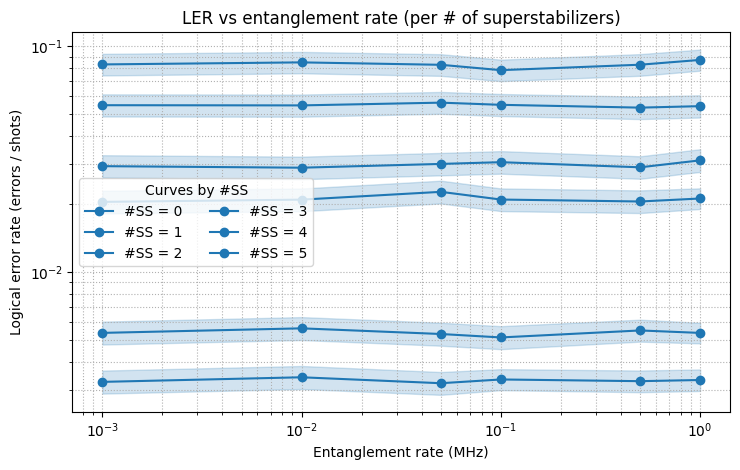

In [31]:

# ---- helpers to read metadata robustly
def get_meta(s):
    m = getattr(s, "json_metadata", None)
    if m is None:
        t = getattr(s, "task", None)
        m = getattr(t, "metadata", {}) if t is not None else {}
    return m or {}

def ndef_of(s):
    v = get_meta(s).get("ndefects", None)
    try: return int(v) if v is not None else None
    except: return None

def rate_of(s):
    v = get_meta(s).get("ent_rate_mhz", None)
    try: return float(v) if v is not None else None
    except: return None

# Group by ndefects (each curve is a #superstabilizers)
def group_key(s): return ndef_of(s)

# Sort each group by rate for a tidy line
from collections import defaultdict
by_group = defaultdict(list)
for s in stats:
    if ndef_of(s) is not None and rate_of(s) is not None:
        by_group[group_key(s)].append(s)
for k in list(by_group.keys()):
    by_group[k] = sorted(by_group[k], key=rate_of)

# ---- plot
fig, ax = plt.subplots(figsize=(7.5, 4.8))

# Assign deterministic colors per ndefects
for i, (ndef, group_stats) in enumerate(sorted(by_group.items(), key=lambda kv: kv[0])):
    sinter.plot_error_rate(
        ax=ax,
        stats=group_stats,
        x_func=lambda s: rate_of(s),
        failure_values_func=lambda s: int(s.errors),
        failure_units_per_shot_func=lambda s: 1,          # IMPORTANT: units per shot = 1
        group_func=lambda s: None,                        # single curve per call
        filter_func=lambda s: True,
        plot_args_func=lambda idx, g, gs: dict(
            marker="o",
            linestyle="-",
            label=f"#SS = {ndef}",                        # label = number of superstabilizers
        ),
        # line_fits=(),
        point_label_func=lambda s: None,
    )

ax.set_xlabel("Entanglement rate (MHz)")
ax.set_ylabel("Logical error rate (errors / shots)")
ax.set_xscale("log")     # MHz 1 → 500 often clearer on log-x; remove if you prefer linear
ax.set_yscale("log")
ax.set_title("LER vs entanglement rate (per # of superstabilizers)")
ax.grid(True, which="both", ls=":")
ax.legend(title="Curves by #SS", ncol=2)
plt.tight_layout()
plt.show()


In [34]:
baseline_ent_stats

[]